## Аналитика в Яндекс.Афише

В нашем распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Оперируя этой информацией, рассчитаем продуктовые метрики, оценим показатели продаж и эффективность расходов на маркетинг.

### Описание данных

Таблица `visits` (лог сервера с информацией о посещениях сайта):
- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь

Таблица `orders` (информация о заказах):
- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа

Таблица `costs` (информация о затратах на маркетинг):
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

## Структура документа

[1. Общая информация и подготовка данных](#step1)

[2. Продуктовые метрики](#step2)

[3. Показатели продаж](#step3)

[4. Оценка эффективности маркетинговых кампаний](#step4)

[5. Общие выводы](#step5)

## <a id="step1"> 1. Общая информация и подготовка данных </a>

Загрузим данные и оценим содержимое таблиц.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [2]:
visits.info()
visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [3]:
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [4]:
costs.info()
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Для каждой таблицы избавимся от пробелов в названиях столбцов и приведем их к нижнему регистру. Также преобразуем все даты в тип данных `datetime`

In [5]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%Y-%m-%d %H:%M:%S')
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format='%Y-%m-%d %H:%M:%S')

In [6]:
visits.info()
visits.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740


In [7]:
orders.columns = ['buy_ts', 'revenue', 'uid']
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format='%Y-%m-%d %H:%M:%S')

In [8]:
orders.info()
orders.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447


In [9]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs.info()
costs.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25


Проверим данные на дубликаты:

In [10]:
visits.duplicated().sum()

0

In [11]:
orders.duplicated().sum()

0

In [12]:
costs.duplicated().sum()

0

Убедились, что исходные данные приведены к наиболее удобному для дальнейшей обработки формату, типы данных преобразованы, а дубликаты отсутствуют. Можем переходить к исследованию и вычислению продуктовых метрик.

## <a id="step2"> 2. Продуктовые метрики </a>

**Сколько людей пользуются в день, неделю, месяц?**

Добавим в таблицу `visits` столбцы, в которых будет содержаться информация о годе, месяце, неделе и дате визита.

In [13]:
visits['year'] = visits['start_ts'].dt.year
visits['month'] = visits['start_ts'].dt.month
visits['week'] = visits['start_ts'].dt.week
visits['date'] = visits['start_ts'].dt.date
visits.head(2)

,device,end_ts,source_id,start_ts,uid,year,month,week,date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19


Произведем расчет следующих метрик:
- `DAU` (Daily Active Users) - среднее количество уникальных пользователей в день;
- `WAU` (Weekly Active Users) - среднее количество уникальных пользователей в неделю;
- `MAU` (Monthly Active Users) - среднее количество уникальных пользователей в месяц.

In [14]:
total_dau = visits.groupby('date').agg({'uid': 'nunique'}).mean()
int(total_dau)

907

In [15]:
total_wau = visits.groupby(['year', 'week']).agg({'uid': 'nunique'}).mean()
int(total_wau)

5716

In [16]:
total_mau = visits.groupby(['year', 'month']).agg({'uid': 'nunique'}).mean()
int(total_mau)

23228

Получили следующие результаты:
- `DAU` = **907**
- `WAU` = **5716**
- `MAU` = **23228**

Рассчитаем также недельное и месячное значения степени вовлечения (`Sticky Factor`): 

In [17]:
sticky_wau = total_dau / total_wau * 100
sticky_wau.round(2)

uid    15.88
dtype: float64

In [18]:
sticky_mau = total_dau / total_mau * 100
sticky_mau.round(2)

uid    3.91
dtype: float64

Не самые выдающиеся показатели по степени вовлечения, но для сервиса вроде афиши это нормально. Типичным сценарием использования скорей всего будет рассмотрение мероприятий в выходные, что не подразумевает ежедневного использования.

Определим значения обозначенных выше метрик сгруппировав пользователей по устройству, с которого было совершено посещение сервиса (*desktop* или *touch*)

In [19]:
desktop_visits = visits.query('device == "desktop"')
desktop_dau = desktop_visits.groupby('date').agg({'uid': 'nunique'}).mean()
int(desktop_dau)

659

In [20]:
desktop_wau = desktop_visits.groupby(['year', 'week']).agg({'uid': 'nunique'}).mean()
int(desktop_wau)

4129

In [21]:
desktop_mau = desktop_visits.groupby(['year', 'month']).agg({'uid': 'nunique'}).mean()
int(desktop_mau)

16724

In [22]:
touch_visits = visits.query('device == "touch"')
touch_dau = touch_visits.groupby('date').agg({'uid': 'nunique'}).mean()
int(touch_dau)

252

In [23]:
touch_wau = touch_visits.groupby(['year', 'week']).agg({'uid': 'nunique'}).mean()
int(touch_wau)

1634

In [24]:
touch_mau = touch_visits.groupby(['year', 'month']).agg({'uid': 'nunique'}).mean()
int(touch_mau)

6825

Показатели среднего количества уникальных пользователей с компьютеров превышают таковые для мобильных устройств примерно **в 2,5 раза**

**Сколько сессий в день?**

Оценим количество сессий в день:

In [25]:
sessions_per_day = visits.groupby('date').agg({'uid': ['count','nunique']})
sessions_per_day.columns = ['n_sessions', 'n_users']
sessions_per_day.head()

,n_sessions,n_users
date,,
2017-06-01,664,605
2017-06-02,658,608
2017-06-03,477,445
2017-06-04,510,476
2017-06-05,893,820


987

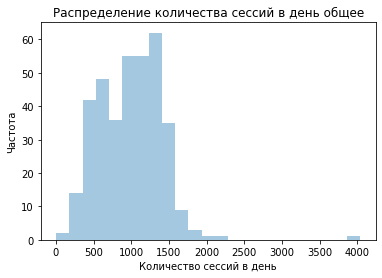

In [26]:
plt.title('Распределение количества сессий в день общее')
sns.distplot(sessions_per_day['n_sessions'], kde=False);
plt.xlabel('Количество сессий в день')
plt.ylabel('Частота')
sessions_per_day['n_sessions'].mean().astype(int)

In [27]:
desktop_sessions_per_day = desktop_visits.groupby('date').agg({'uid': ['count','nunique']})
desktop_sessions_per_day.columns = ['n_sessions', 'n_users']
desktop_sessions_per_day.head()

,n_sessions,n_users
date,,
2017-06-01,501,455
2017-06-02,498,458
2017-06-03,329,307
2017-06-04,349,326
2017-06-05,693,631


721

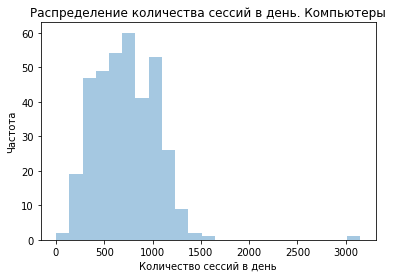

In [28]:
plt.title('Распределение количества сессий в день. Компьютеры')
sns.distplot(desktop_sessions_per_day['n_sessions'], kde=False);
plt.xlabel('Количество сессий в день')
plt.ylabel('Частота')
desktop_sessions_per_day['n_sessions'].mean().astype(int)

In [29]:
touch_sessions_per_day = touch_visits.groupby('date').agg({'uid': ['count','nunique']})
touch_sessions_per_day.columns = ['n_sessions', 'n_users']
touch_sessions_per_day.head()

,n_sessions,n_users
date,,
2017-06-01,163,153
2017-06-02,160,152
2017-06-03,148,139
2017-06-04,161,153
2017-06-05,200,195


266

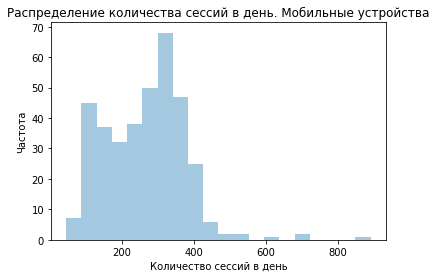

In [30]:
plt.title('Распределение количества сессий в день. Мобильные устройства')
sns.distplot(touch_sessions_per_day['n_sessions'], kde=False);
plt.xlabel('Количество сессий в день')
plt.ylabel('Частота')
touch_sessions_per_day['n_sessions'].mean().astype(int)

**Количество сессий** в день составило в среднем **987 штук**. Из этого количества **721** приходится на **компьютеры** и **266** на **мобильные устройства**.

**Сколько длится одна сессия?**

Далее рассчитаем метрику *ASL (average session length)* для всех сессий, а также для разных типов устройств.

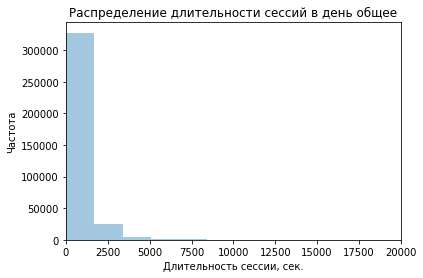

In [31]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
plt.title('Распределение длительности сессий в день общее')
sns.distplot(visits['session_duration_sec'], kde=False)
plt.xlim(0, 20000)
plt.xlabel('Длительность сессии, сек.')
plt.ylabel('Частота');

In [32]:
visits['session_duration_sec'].mode()

0    60
dtype: int64

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


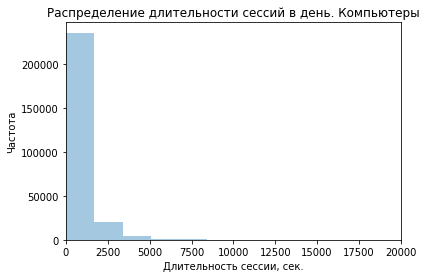

In [33]:
desktop_visits['session_duration_sec'] = (desktop_visits['end_ts'] - desktop_visits['start_ts']).dt.seconds
plt.title('Распределение длительности сессий в день. Компьютеры')
sns.distplot(desktop_visits['session_duration_sec'], kde=False)
plt.xlim(0, 20000)
plt.xlabel('Длительность сессии, сек.')
plt.ylabel('Частота');

In [34]:
desktop_visits['session_duration_sec'].mode()

0    60
dtype: int64

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


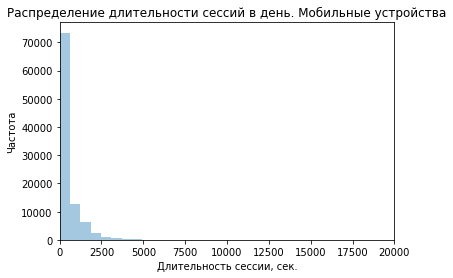

In [35]:
touch_visits['session_duration_sec'] = (touch_visits['end_ts'] - touch_visits['start_ts']).dt.seconds
plt.title('Распределение длительности сессий в день. Мобильные устройства')
sns.distplot(touch_visits['session_duration_sec'], kde=False)
plt.xlim(0, 20000)
plt.xlabel('Длительность сессии, сек.')
plt.ylabel('Частота');

In [36]:
touch_visits['session_duration_sec'].mode()

0    60
dtype: int64

Распределение длительности сессий для всех типов устройств отличается от нормального и в данном случае наиболее подходящей статистической мерой будет мода (наиболее часто встречающееся значение). Мода времени длительности сессии как для компьютеров, так и для мобильных устройств составила **60 секунд**.

Равенство этого показателя может говорить о том, что тип устройства не оказывает значительного влияния на длительность посещения сервиса.

Рассчитаем количество сессий на одного пользователя:

In [37]:
sessions_per_user = len(visits) / len(visits['uid'].unique())
round(sessions_per_user, 2)

1.58

На одного пользователя в среднем приходится **1,58 сессии**. Это говорит о том, что пользователи редко пользуются сервисом.

**Как часто люди возвращаются?**

Определим `Retention Rate` (коэффициент удержания) пользователей сервиса. Разделим пользователей на когорты по месяцу первого посещения.

In [38]:
# Найдем месяц первого визита и добавим к таблице visits
first_visit_date = visits.groupby('uid')['date'].min()
first_visit_date.name = 'first_visit_date'
visits = visits.join(first_visit_date, on='uid')

In [39]:
# Создадим столбцы с месяцем визита и месяцем первого визита
visits['first_visit_date'] = pd.to_datetime(visits['first_visit_date'])
visits['first_visit_month'] = visits['first_visit_date'].astype('datetime64[M]')
visits['visit_month'] = visits['date'].astype('datetime64[M]')

In [40]:
# Определим lifetime каждой строки в рамках когорты
visits['cohort_lifetime'] = ((visits['visit_month'] - visits['first_visit_month']) / np.timedelta64(1,'M')).astype(int)
visits.head()

,device,end_ts,source_id,start_ts,uid,year,month,week,date,session_duration_sec,first_visit_date,first_visit_month,visit_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080,2017-12-20,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680,2018-02-19,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0,2017-07-01,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440,2018-03-09,2018-03-01,2018-05-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0,2017-12-27,2017-12-01,2017-12-01,0


In [41]:
# Найдем для каждой когорты количество активных пользователей по месяцам
cohorts = visits.groupby(['first_visit_month', 'cohort_lifetime']).agg({'uid': 'nunique'}).reset_index()

# Найдем начальное количество пользователей в каждой когорте
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

# Добавим начальное количество пользователей к таблице cohorts
cohorts = cohorts.merge(initial_users_count,on='first_visit_month')
cohorts.head()

,first_visit_month,cohort_lifetime,uid,cohort_users
0,2017-06-01,0,13259,13259
1,2017-06-01,2,713,13259
2,2017-06-01,3,814,13259
3,2017-06-01,4,909,13259
4,2017-06-01,5,947,13259


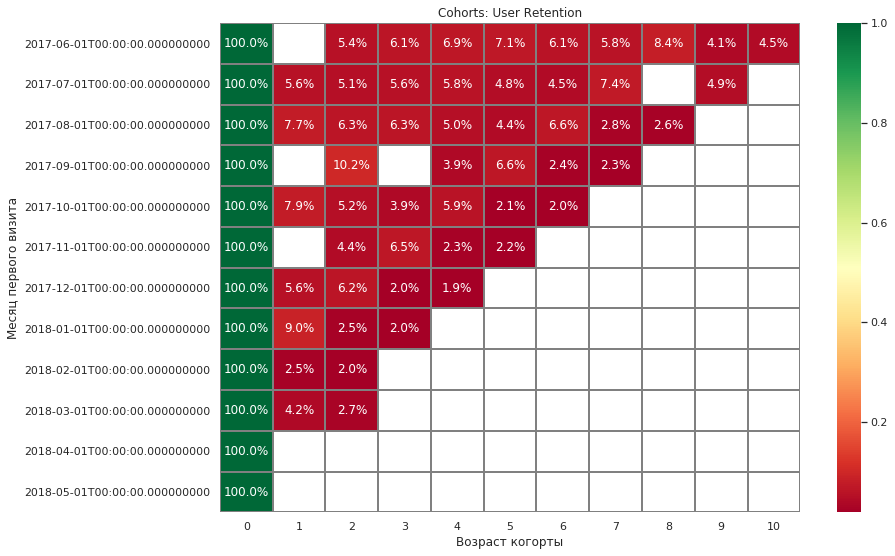

In [42]:
# Рассчитаем значение показателя Retention
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']

# Построим сводную таблицу по Retention и визуализируем результат.
retention_pivot = cohorts.pivot_table(index='first_visit_month', columns='cohort_lifetime', values='retention', aggfunc='sum')

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', cmap='RdYlGn')
plt.xlabel('Возраст когорты')
plt.ylabel('Месяц первого визита');

По показателям Retention Rate для месячных когорт пользователей можно сделать следующие выводы:
- в месяц, следующий за месяцем первого посещения Афиши возвращаются менее 10% пользователей;
- для когорт, сформированных до сентября 2017 года первые 3-5 месяцев показатели стабильны и колеблются в пределах 2%;
- прослеживаются всплески посещаемости в ноябре 2017 и феврале 2018. Это может быть связано с сезонностью или увеличением маркетингового бюджета;
- начиная с марта 2018 показатель для всех когорт кроме двух первых и последних падает до примерно 2%. Эти данные также нужно сопоставить с затратами на маркетинг;
- присутствуют пробелы в данных по некоторым когортам. Следует связаться с поставщиком данных и выяснить возможные причины.

В целом, можно сказать, что по прошествии нескольких месяцев в постоянных посетителей Афиши конвертируются 2-4% от общего количества в зависимости от периода первого посещения.

Общая картина с посещениями сервиса понятна. Разберемся, сколько денег приносят пользователи.

## <a id="step3"> 3. Показатели продаж </a>

**Когда люди начинают покупать?**

Выясним, когда в среднем происходит первая покупка и сколько таких покупок в месяц.

Когорты будем формировать по месяцу первого посещения сервиса, это как раз и позволит соотнести данный показатель со временем первой покупки.

In [43]:
# Добавим к таблице orders дату первого посещения сервиса
orders = orders.join(first_visit_date, on='uid')
orders['first_visit_date'] = pd.to_datetime(orders['first_visit_date'])

In [44]:
# Выделим время и дату первой сессии и первый маркетинговый источник 
first_sessions = visits.groupby(['uid']).agg({'start_ts':'min', 'source_id':'first'})
first_sessions.columns = ['first_visit_ts', 'first_source']

# Выделим время первой покупки
first_buy = orders.groupby(['uid']).agg({'buy_ts':'min'})
first_buy.columns = ['first_order_ts']

# Добавим дату и время первой сессии в информацию по первым заказам
first_buy = first_buy.join(first_sessions,on='uid')

Медиана времени с первого посещения до первой покупки: 16 минут
Среднее время с первого посещения до первой покупки: 16 дней
Мода времени с первого посещения до первой покупки: 1 минута


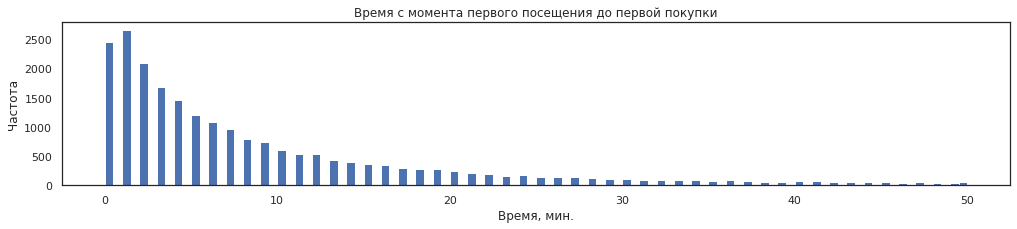

In [45]:
# Найдем время, прошедшее с момента первого посещения до первой покупки
first_buy['time_to_first_order'] = (first_buy['first_order_ts'] - first_buy['first_visit_ts']) / np.timedelta64(1, 'm')
first_buy['time_to_first_order'].plot(kind = 'hist', bins = 100, range = (0,50), figsize = (17,3), title = 'Время с момента первого посещения до первой покупки')
plt.xlabel('Время, мин.')
plt.ylabel('Частота');
print('Медиана времени с первого посещения до первой покупки: {} минут'.format(int(first_buy['time_to_first_order'].median())))
print('Среднее время с первого посещения до первой покупки: {} дней'.format(int(first_buy['time_to_first_order'].mean()/60/24)))
print('Мода времени с первого посещения до первой покупки: {} минута'.format(int(first_buy['time_to_first_order'].mode())))

Распределение далеко от нормального, выбираем моду как наиболее подходящую меру центральной тенденции.

Делаем вывод, что на первую покупку, как и на первое посещение сервиса пользователю чаще всего требуется **1 минута**.

**Сколько раз покупают за период?**

In [46]:
# Добавим столбцы с месяцем первого посещения, месяцем покупки и показателем lifetime для когорт
orders['first_visit_month'] = orders['first_visit_date'].astype('datetime64[M]')
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders['cohort_lifetime'] = ((orders['order_month'] - orders['first_visit_month']) / np.timedelta64(1,'M')).round().astype(int)

In [47]:

orders['order_date'] = orders['buy_ts'].dt.date
orders['order_week'] = orders['buy_ts'].dt.week
orders['order_year'] = orders['buy_ts'].dt.year
day_purchases_per_user = (orders.groupby(['order_date', 'uid']).agg({'buy_ts':'count'}).mean()[0]).round(2)
week_purchases_per_user = (orders.groupby(['order_year', 'order_week', 'uid']).agg({'buy_ts':'count'}).mean()[0]).round(2)
month_purchases_per_user = (orders.groupby(['order_year', 'order_month', 'uid']).agg({'buy_ts':'count'}).mean()[0]).round(2)
day_purchases_per_user
week_purchases_per_user
month_purchases_per_user
print('''В среднем на одного пользователя покупок:
В день - {:.2f},
В неделю - {:.2f},
В месяц - {:.2f}
'''.format(day_purchases_per_user, week_purchases_per_user, month_purchases_per_user))

В среднем на одного пользователя покупок:
В день - 1.08,
В неделю - 1.16,
В месяц - 1.23



Видим подтверждение низких значений показателя Retention Rate. Количество покупок на пользователя в течение месяца невелико.

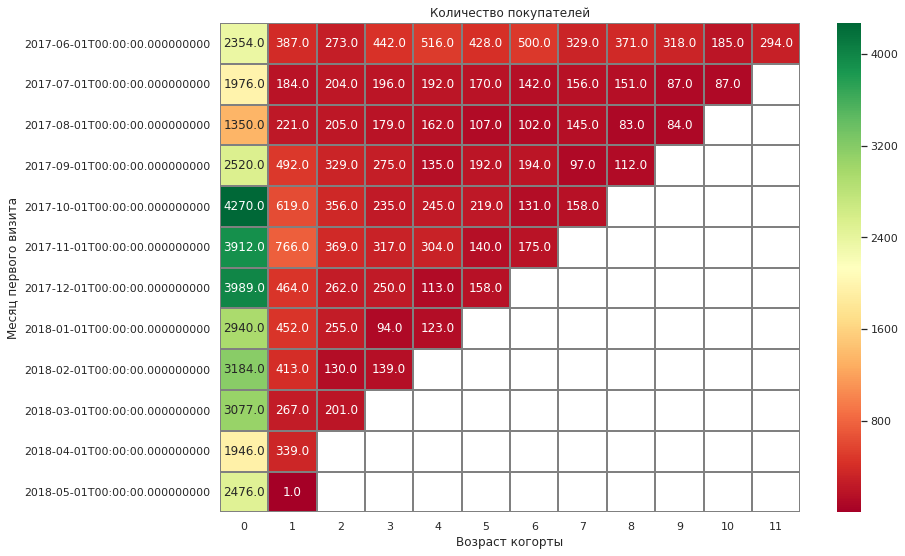

In [48]:
# Построим сводную таблицу, чтобы оценить количество покупок и визуализируем результат
orders_count = orders.pivot_table(index='first_visit_month',
    columns='cohort_lifetime',
    values='uid',
    aggfunc='count')

plt.figure(figsize=(13, 9))
plt.title('Количество покупателей')
sns.heatmap(orders_count, annot=True, fmt='.1f', linewidths=1, linecolor='gray', cmap='RdYlGn')
plt.xlabel('Возраст когорты')
plt.ylabel('Месяц первого визита');

По тепловой карте делаем следующие выводы:
- первые покупки пользователи как правило делают в первый месяц пользования сервисом;
- после первого месяца наблюдается значительный спад количества покупок, что согласуется с количеством посещений, которое также значительно проседает после первого месяца;
- далее для всех когорт кроме первой наблюдается плавное уменьшение количества заказов, то есть вовлеченность пользователей падает;
- в первой когорте наблюдаются увеличения покупок относительно предыдущего периода раз в 2-4 месяца, чередующиеся с затуханием;
- практически во всех когортах в последнем месяце наблюдения можем наблюдать увеличение количества покупок, это может быть связано с запуском рекламной кампании, целью которой стал возврат старых пользователей.

**Какой средний чек?**

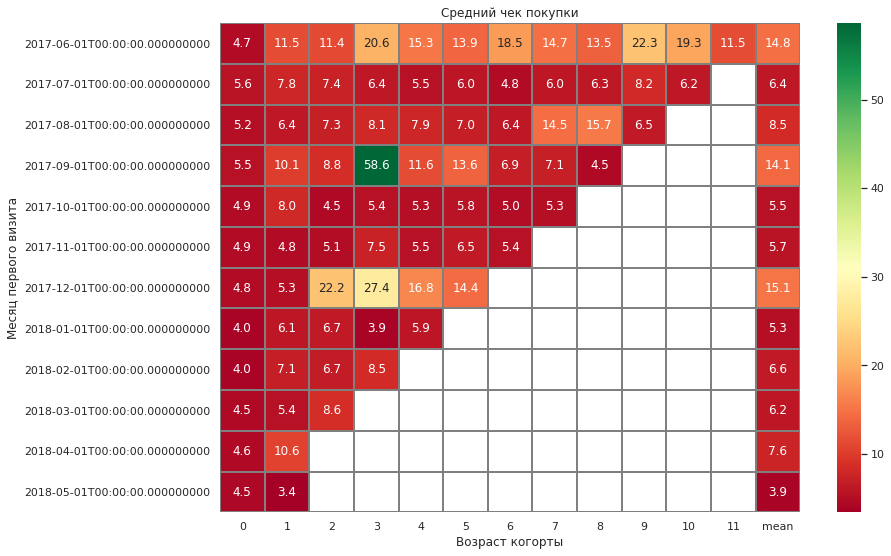

In [49]:
# Сгруппируем заказы по месяцам и сумме выручки, рассчитаем средний чек и показатель lifetime для когорт
orders_grouped_by_cohorts = orders.groupby(['first_visit_month','order_month']).agg({'revenue':'sum','uid':'nunique'}).reset_index()
orders_grouped_by_cohorts['revenue_per_user'] = orders_grouped_by_cohorts['revenue'] / orders_grouped_by_cohorts['uid']
orders_grouped_by_cohorts['cohorts_lifetime'] = ((orders_grouped_by_cohorts['order_month'] - 
                                    orders_grouped_by_cohorts['first_visit_month']) / np.timedelta64(1,'M')).round().astype(int)
# Построим сводную таблицу, чтобы оценить средний чек и визуализируем результат
revenue_per_user = orders_grouped_by_cohorts.pivot_table(index='first_visit_month',
                                      columns='cohorts_lifetime',
                                      values='revenue_per_user',
                                      aggfunc='mean')
revenue_per_user['mean'] = revenue_per_user.mean(axis=1)
plt.figure(figsize=(13, 9))
plt.title('Средний чек покупки')
sns.heatmap(revenue_per_user, annot=True, fmt='.1f', linewidths=1, linecolor='gray', cmap='RdYlGn')
plt.xlabel('Возраст когорты')
plt.ylabel('Месяц первого визита');

Найдем также значения среднего чека для всех заказов:

In [50]:
orders['revenue'].mean().round(1)

5.0

По визуализации данных о среднем чеке можно сделать следующие выводы:
- средний чек к концу периода наблюдений растет относительно первоначального во всех когортах кроме одной;
- по величине среднего чека можно выделить когорты июня и декабря 2017;
- для ряда когорт присутствуют месяцы со скачкообразным ростом среднего чека относительно предыдущего месяца в 3-7 раз с последующим возвратом к исходным значениям за 1-2 месяца;
- наиболее интересными для дальнейшего привлечения являются пользователи когорт июня, сентября и декабря 2017 года;
- средний чек среди всех заказов составляет 5 $.

**Сколько денег приносят? (LTV)**

Рассчитаем показатель `LTV` (Lifetime Value). Это совокупная прибыль, получаемая от одного клиента за все время сотрудничества.

In [51]:
# Найдем месяц первой покупки для каждого покупателя
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

# Рассчитаем количество новых покупателей за каждый месяц
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
#Добавим месяц первой покупки в таблицу orders
orders_new = pd.merge(orders,first_orders, on='uid')
# Сгруппируем данные по месяцу первого заказа и месяцу заказа, найдем суммарную выручку
orders_new = orders_new.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
orders_new.head()

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [52]:
# Добавим в получившуюся таблицу столбец с количеством пользователей в каждой когорте
report = pd.merge(cohort_sizes, orders_new, on='first_order_month')
report.head()

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


Для определения `LTV` нам необходимо оперировать показателем валовой прибыли, которая представляет собой произведение выручки на значение маржинальности.

В исходных данных значения маржинальности нет, рассчитать его из показателей бизнеса так же не представляется возможным.

Будем исходить из того, мы работаем с уже готовым сервисом, на котором размещены данные о различных событиях. Афиша же получает комиссионные за каждый купленный билет. Таким образом, оставив за скобками затраты на разработку сервиса, аренду серверных мощностей и добавление информации о мероприятиях, возьмем за основу то, что выручка равна валовой прибыли, а маржинальность равна 100%.

Тогда `LTV` рассчитаем как отношение выручки к количеству пользователей, совершивших покупку.

In [53]:
report['ltv'] = report['revenue'] / report['n_buyers']
# Добавим также столбец с данными о lifetime
report['cohort_lifetime'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['cohort_lifetime'] = report['cohort_lifetime'].round().astype(int)
report.head()

,first_order_month,n_buyers,order_month,revenue,ltv,cohort_lifetime
0,2017-06-01,2023,2017-06-01,9557.49,4.724414,0
1,2017-06-01,2023,2017-07-01,981.82,0.485329,1
2,2017-06-01,2023,2017-08-01,885.34,0.437637,2
3,2017-06-01,2023,2017-09-01,1931.30,0.954671,3
4,2017-06-01,2023,2017-10-01,2068.58,1.022531,4


Построим сводную таблицу, в которой вычислим среднее значение `LTV` для каждой когорты по месяцам.

In [54]:
ltv = report.pivot_table(
        index='first_order_month', 
        columns='cohort_lifetime', 
        values='ltv', 
        aggfunc='mean').round(2)
    
ltv.fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,0.49,0.44,0.95,1.02,0.74,0.95,0.58,0.55,0.61,0.57,0.26
2017-07-01,6.01,0.34,0.62,0.36,0.18,0.16,0.12,0.14,0.16,0.15,0.16,
2017-08-01,5.28,0.47,0.46,0.39,0.49,0.28,0.21,0.41,0.29,0.19,,
2017-09-01,5.64,1.12,0.52,3.98,0.4,0.65,0.7,0.24,0.18,,,
2017-10-01,5.00,0.54,0.19,0.16,0.15,0.12,0.08,0.12,,,,
2017-11-01,5.15,0.4,0.2,0.32,0.15,0.05,0.11,,,,,
2017-12-01,4.74,0.26,0.93,1.07,0.31,0.34,,,,,,
2018-01-01,4.14,0.29,0.3,0.14,0.06,,,,,,,
2018-02-01,4.16,0.28,0.08,0.07,,,,,,,,


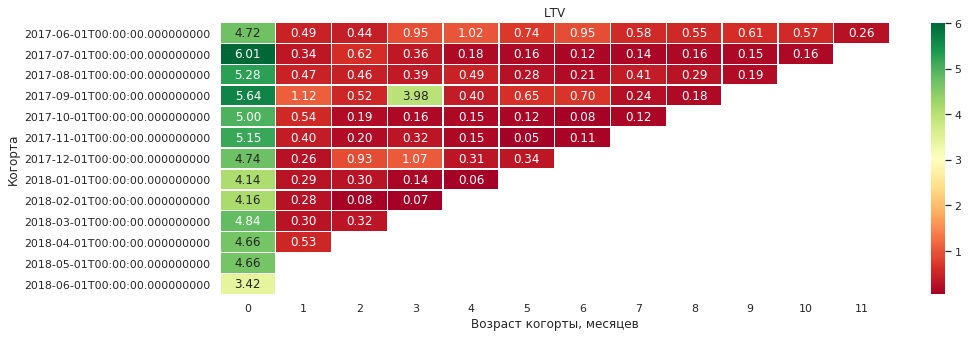

In [55]:
# Визуализируем полученные данные
plt.figure(figsize=(15, 5))
plt.title('LTV')
sns.heatmap(ltv, annot=True, fmt=".2f", linewidths=.5, cmap = 'RdYlGn')
plt.xlabel('Возраст когорты, месяцев')
plt.ylabel('Когорта');

Найдем также суммарный `LTV` для каждой когорты

In [56]:
ltv_sum = ltv.sum(axis=1)
ltv_sum

first_order_month
2017-06-01    11.88
2017-07-01     8.40
2017-08-01     8.47
2017-09-01    13.43
2017-10-01     6.36
2017-11-01     6.38
2017-12-01     7.65
2018-01-01     4.93
2018-02-01     4.59
2018-03-01     5.46
2018-04-01     5.19
2018-05-01     4.66
2018-06-01     3.42
dtype: float64

Мы имеем информацию о том, сколько в среднем денег принес пользователь каждой когорты. Однако оценивать этот показатель лучше всего в связке с расходами, которые понесла компания на привлечение каждого покупателя. Перейдем к расчету этого показателя.

## <a id="step4"> 4. Оценка эффективности маркетинговых кампаний </a>

**Сколько денег потратили? Всего / на каждый источник / по времени**

Найдем следующие значения:
- общая сумма расходов на маркетинг;
- сумма расходов в разбивке по месяцам;
- сумма расходов в разбивке по источникам.

In [57]:
costs['month'] = costs['dt'].astype('datetime64[M]')
total_costs = costs['costs'].sum()
total_costs

329131.62

Всего за исследуемый период затраты на маркетинг составили **329 131.62 $**

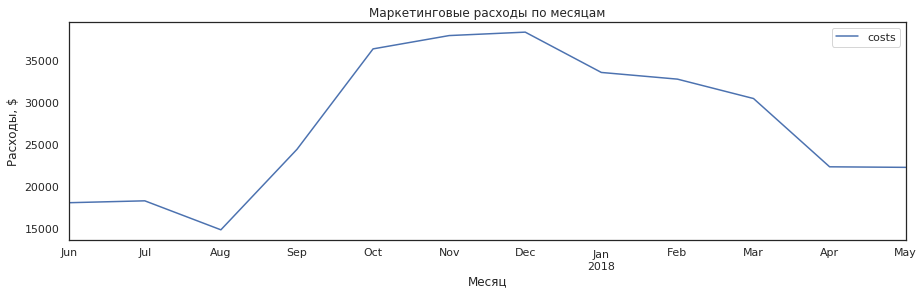

In [58]:
costs_months = costs.groupby('month').agg({'costs': 'sum'}).plot(title = 'Маркетинговые расходы по месяцам', figsize = (15,4))
plt.xlabel('Месяц')
plt.ylabel('Расходы, $')
plt.show()

In [59]:
costs_sources = costs.groupby('source_id').agg({'costs': 'sum'}) 

costs_sources

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


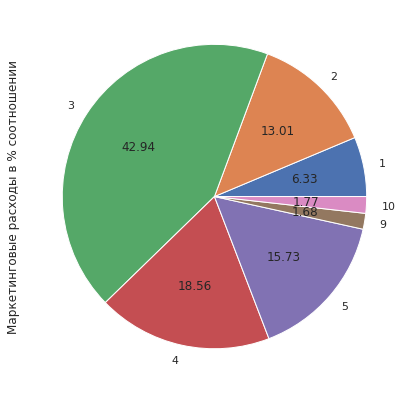

In [60]:
costs.groupby('source_id').agg({'costs': 'sum'}).plot(y = 'costs', 
                                                      autopct='%.2f', 
                                                      kind = 'pie', 
                                                      figsize = (7, 7), 
                                                      legend = False);
plt.ylabel('Маркетинговые расходы в % соотношении')
plt.show();

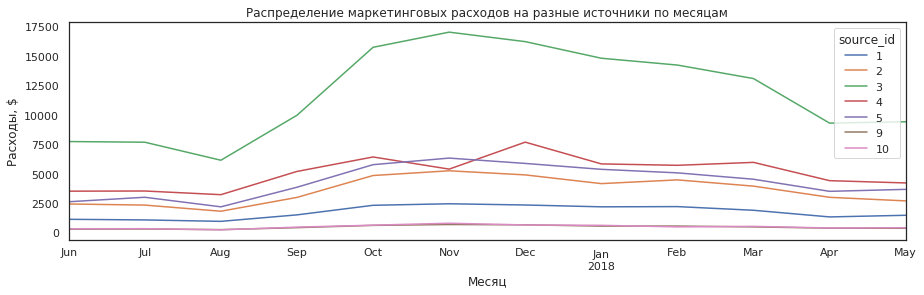

In [61]:
costs_sourses_months = costs.pivot_table(index='month', columns='source_id', values='costs', aggfunc='sum')
costs_sourses_months.plot(figsize = (15,4), title = 'Распределение маркетинговых расходов на разные источники по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Расходы, $')
plt.show();

Видим, что маркетинговый бюджет был самым большим с октября по декабрь 2017, а в разбивке по источникам на фоне остальных заметно выделяется источник №3.

#### Определим, сколько стоило привлечение одного покупателя из каждого источника.

Напрямую оценить количество покупателей из каждого источника мы не можем. Но можно оценить стоимость и источник привлечения одного посетителя. Затем выделить среди посетителей тех, кто совершил покупки. Источником привлечения покупателя будем считать его **первый** источник посещения (Да, покупка может быть совершена не сразу и после перехода с другого источника. Но первое знакомство пользователя с сервисом и история его дальнейших действий будет отсчитываться от первого визита).

Найдем распределение посетителей по источникам с течением времени

In [62]:
visits_sources = visits.pivot_table(index='visit_month', columns='source_id', values='uid', aggfunc='count')
visits_sources.head()

source_id,1,2,3,4,5,6,7,9,10
visit_month,,,,,,,,,
2017-06-01,1544.0,2191.0,4435.0,3911.0,3122.0,NaN,2.0,823.0,477.0
2017-07-01,1641.0,2488.0,4276.0,4402.0,4056.0,1.0,2.0,621.0,341.0
2017-08-01,1251.0,1866.0,3582.0,3298.0,3403.0,1.0,1.0,684.0,269.0
2017-09-01,2082.0,3025.0,6102.0,5791.0,5489.0,1.0,3.0,874.0,540.0
2017-10-01,3282.0,4642.0,9017.0,10484.0,8303.0,NaN,5.0,1166.0,1004.0


Определим расходы на привлечение клиентов по источникам с течением времени

In [63]:
costs_sources = costs.pivot_table(index='month', columns='source_id', values='costs', aggfunc='sum')
costs_sources.head()

source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22
2017-07-01,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82
2017-08-01,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57
2017-09-01,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67
2017-10-01,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24


Из таблицы `visits_sources` удалим столбцы с данными из источников 6 и 7. Маркетинговых затрат на эти источники нет, а количество посещений ничтожно мало в сравнении с другими источниками.

In [64]:
visits_sources = visits_sources[[1, 2, 3, 4, 5, 9, 10]]
visits_sources.head()

source_id,1,2,3,4,5,9,10
visit_month,,,,,,,
2017-06-01,1544.0,2191.0,4435.0,3911.0,3122.0,823.0,477.0
2017-07-01,1641.0,2488.0,4276.0,4402.0,4056.0,621.0,341.0
2017-08-01,1251.0,1866.0,3582.0,3298.0,3403.0,684.0,269.0
2017-09-01,2082.0,3025.0,6102.0,5791.0,5489.0,874.0,540.0
2017-10-01,3282.0,4642.0,9017.0,10484.0,8303.0,1166.0,1004.0


Оценим стоимость привлечения одного посетителя по источникам в каждом месяце.

In [65]:
cost_of_visit = (costs_sources / visits_sources).round(2)
cost_of_visit.head()

source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,0.73,1.11,1.74,0.90,0.84,0.35,0.66
2017-07-01,0.65,0.94,1.79,0.80,0.74,0.49,0.97
2017-08-01,0.76,0.97,1.72,0.98,0.64,0.36,0.86
2017-09-01,0.72,0.99,1.63,0.90,0.70,0.48,0.85
2017-10-01,0.71,1.04,1.75,0.61,0.69,0.52,0.62


Выделим в новую таблицу информацию о пользователях и времени покупки из таблицы `orders`

In [66]:
orders_new = orders[['uid', 'buy_ts']]
orders_new.head(2)

,uid,buy_ts
0,10329302124590727494,2017-06-01 00:10:00
1,11627257723692907447,2017-06-01 00:25:00


Выделим в новую таблицу информацию о пользователях и времени покупки из таблицы `visits` и добавим к ней информацию о времени покупки. 

In [67]:
visits_by_sources = visits[['uid', 'start_ts', 'end_ts', 'source_id', 'device']]
visits_by_sources = visits_by_sources.merge(orders_new, how='right')

Выделим среди всех посещений пользователей с покупками первый.

In [68]:
visit_with_order = visits_by_sources.groupby('uid')['start_ts'].min()
visit_with_order.name = 'first_session'
visit_with_order.head(2)

uid
313578113262317    2017-09-18 22:49:00
1575281904278712   2017-06-03 10:13:00
Name: first_session, dtype: datetime64[ns]

In [69]:
# Добавим к новой таблице с посещениями время первого посещения
visits_by_sources = visits_by_sources.join(visit_with_order, on='uid')

In [70]:
# Сформируем срез по первому посещению, получив тем самым источник первого посещения для пользователей, которые совершили покупки
visits_by_sources = visits_by_sources.query('start_ts == first_session')
visits_by_sources['month'] = visits_by_sources['buy_ts'].astype('datetime64[M]')
visits_by_sources.info()
visits_by_sources.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50415 entries, 1 to 761806
Data columns (total 8 columns):
uid              50415 non-null uint64
start_ts         50415 non-null datetime64[ns]
end_ts           50415 non-null datetime64[ns]
source_id        50415 non-null int64
device           50415 non-null object
buy_ts           50415 non-null datetime64[ns]
first_session    50415 non-null datetime64[ns]
month            50415 non-null datetime64[ns]
dtypes: datetime64[ns](5), int64(1), object(1), uint64(1)
memory usage: 3.5+ MB


,uid,start_ts,end_ts,source_id,device,buy_ts,first_session,month
1,16174680259334210214,2018-03-09 20:05:00,2018-03-09 20:33:00,4,desktop,2018-03-09 20:25:00,2018-03-09 20:05:00,2018-03-01
2,16007536194108375387,2017-09-03 21:35:00,2017-09-03 21:36:00,5,desktop,2017-09-04 12:46:00,2017-09-03 21:35:00,2017-09-01


Количество строк в таблице `visits_by_sources` после преобразований совпадает с таковым в тблице `orders`. Таким образом, для каждой покупки мы получили маркетинговый источник, по которому пользователь совершил первое посещение сервиса.

Рассчитаем количество заказов по источникам с течением времени.

In [71]:
order_sources = visits_by_sources.pivot_table(index='month', columns='source_id', values='uid', aggfunc='count')
order_sources

source_id,1,2,3,4,5,7,9,10
month,,,,,,,,
2017-06-01,268.0,281.0,704.0,467.0,447.0,NaN,79.0,108.0
2017-07-01,261.0,279.0,577.0,585.0,538.0,NaN,65.0,58.0
2017-08-01,243.0,180.0,405.0,394.0,455.0,1.0,88.0,41.0
2017-09-01,449.0,345.0,918.0,684.0,759.0,NaN,135.0,97.0
2017-10-01,587.0,649.0,1411.0,1416.0,1194.0,NaN,190.0,232.0
2017-11-01,570.0,686.0,1561.0,1510.0,935.0,NaN,238.0,159.0
2017-12-01,622.0,714.0,1669.0,1770.0,1169.0,NaN,174.0,100.0
2018-01-01,466.0,568.0,1261.0,1305.0,886.0,NaN,133.0,102.0
2018-02-01,491.0,695.0,1417.0,1423.0,968.0,NaN,138.0,149.0


На источник 7 не были затрачены средства в рамках маркетинговых кампаний, а количество заказов за исследуемый период равно одному, удалим этот столбец из выборки.

Также удалим строку с данными об июне 2018, где присутствует только один заказ.

In [72]:
order_sources = order_sources[[1, 2, 3, 4, 5, 9, 10]]
order_sources.drop(order_sources.tail(1).index,inplace=True)
order_sources

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,268.0,281.0,704.0,467.0,447.0,79.0,108.0
2017-07-01,261.0,279.0,577.0,585.0,538.0,65.0,58.0
2017-08-01,243.0,180.0,405.0,394.0,455.0,88.0,41.0
2017-09-01,449.0,345.0,918.0,684.0,759.0,135.0,97.0
2017-10-01,587.0,649.0,1411.0,1416.0,1194.0,190.0,232.0
2017-11-01,570.0,686.0,1561.0,1510.0,935.0,238.0,159.0
2017-12-01,622.0,714.0,1669.0,1770.0,1169.0,174.0,100.0
2018-01-01,466.0,568.0,1261.0,1305.0,886.0,133.0,102.0
2018-02-01,491.0,695.0,1417.0,1423.0,968.0,138.0,149.0


Вычислим стоимость привлечения одного покупателя по источникам с течением времени.

In [73]:
cost_of_order = (costs_sources / order_sources).round(2)
cost_of_order

source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,4.20,8.64,10.98,7.53,5.85,3.61,2.91
2017-07-01,4.11,8.36,13.30,6.03,5.57,4.65,5.69
2017-08-01,3.92,10.06,15.17,8.17,4.80,2.83,5.67
2017-09-01,3.35,8.65,10.85,7.59,5.07,3.08,4.75
2017-10-01,3.95,7.47,11.15,4.53,4.83,3.21,2.70
2017-11-01,4.29,7.65,10.91,3.57,6.77,2.87,4.98
2017-12-01,3.76,6.86,9.72,4.34,5.02,3.78,6.46
2018-01-01,4.69,7.32,11.74,4.47,6.06,4.11,6.02
2018-02-01,4.49,6.44,10.04,4.01,5.24,4.00,3.23


Вычислим конверсию по источникам с течением времени.

In [74]:
conversion_by_sources = (order_sources / visits_sources).round(2)
conversion_by_sources

source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,0.17,0.13,0.16,0.12,0.14,0.10,0.23
2017-07-01,0.16,0.11,0.13,0.13,0.13,0.10,0.17
2017-08-01,0.19,0.10,0.11,0.12,0.13,0.13,0.15
2017-09-01,0.22,0.11,0.15,0.12,0.14,0.15,0.18
2017-10-01,0.18,0.14,0.16,0.14,0.14,0.16,0.23
2017-11-01,0.13,0.11,0.14,0.12,0.13,0.14,0.15
2017-12-01,0.14,0.13,0.17,0.13,0.17,0.12,0.14
2018-01-01,0.14,0.12,0.14,0.12,0.14,0.11,0.08
2018-02-01,0.14,0.15,0.15,0.13,0.14,0.12,0.11


Визуализируем все полученные значения.

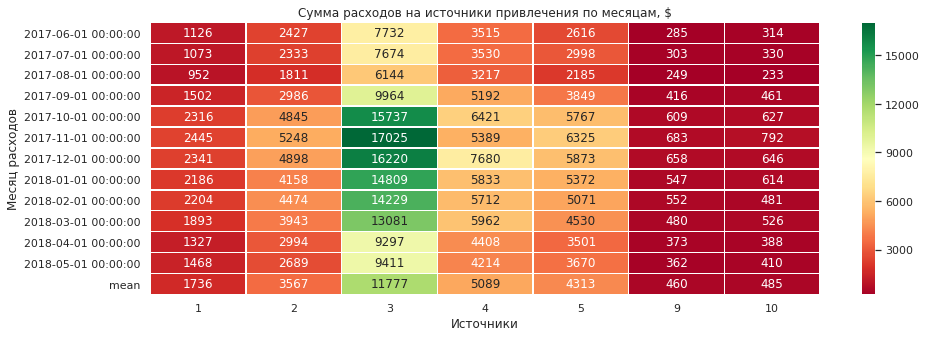

In [75]:
costs_sources.loc['mean'] = costs_sources.mean()
plt.figure(figsize=(15, 5))
plt.title('Сумма расходов на источники привлечения по месяцам, $')
sns.heatmap(costs_sources, annot=True, fmt=".0f", linewidths=.5, cmap='RdYlGn')
plt.xlabel('Источники')
plt.ylabel('Месяц расходов')
plt.show()

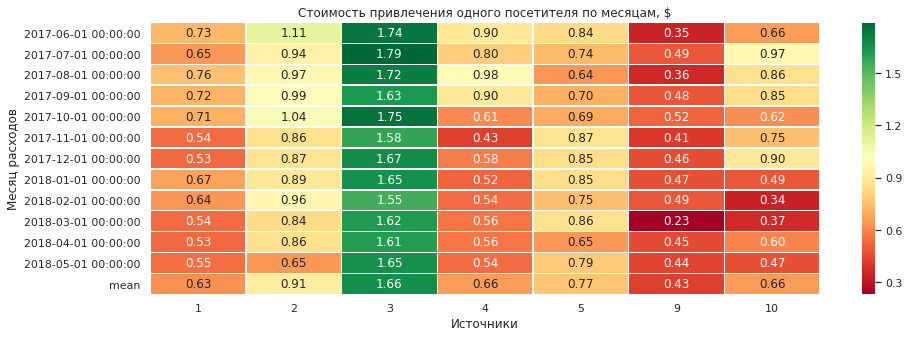

In [76]:
cost_of_visit.loc['mean'] = cost_of_visit.mean()
plt.figure(figsize=(15, 5))
plt.title('Стоимость привлечения одного посетителя по месяцам, $')
sns.heatmap(cost_of_visit, annot=True, fmt=".2f", linewidths=.5, cmap='RdYlGn')
plt.xlabel('Источники')
plt.ylabel('Месяц расходов')
plt.show()

Посетители из источника 3 обходятся дороже других. В то время как источники 1, 4, 9, 10 показывают более низкие показатели.

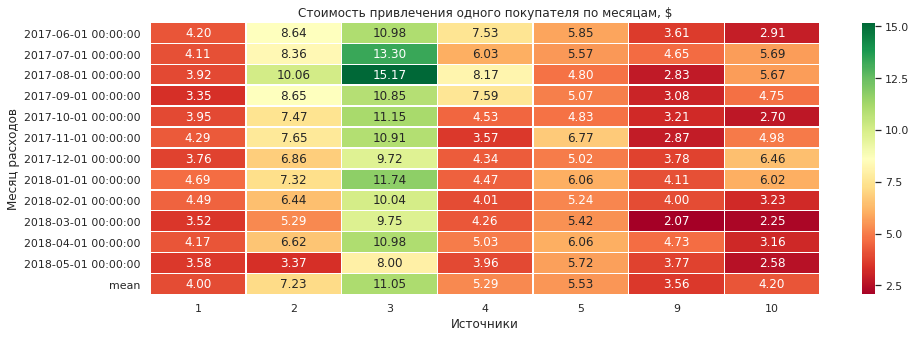

In [77]:
cost_of_order.loc['mean'] = cost_of_order.mean()
plt.figure(figsize=(15, 5))
plt.title('Стоимость привлечения одного покупателя по месяцам, $')
sns.heatmap(cost_of_order, annot=True, fmt=".2f", linewidths=.5, cmap='RdYlGn')
plt.xlabel('Источники')
plt.ylabel('Месяц расходов')
plt.show()

Вспомним значение среднего чека в 5 $ и видим, что покупатели, пришедшие через источник 3, на который, к слову, тратится 42% маркетингового бюджетаобходятся более чем в 2 раза дороже.

Вписываются в эту сумму источники 1, 9 и 10.

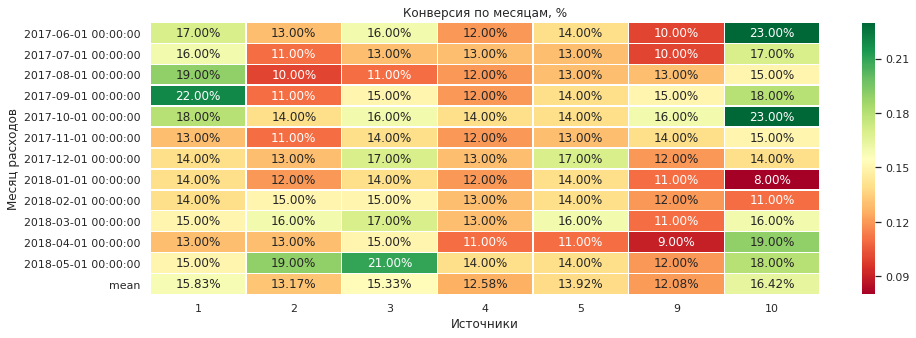

In [78]:
conversion_by_sources.loc['mean'] = conversion_by_sources.mean()
plt.figure(figsize=(15, 5))
plt.title('Конверсия по месяцам, %')
sns.heatmap(conversion_by_sources, annot=True, fmt=".2%", linewidths=.5, cmap='RdYlGn')
plt.xlabel('Источники')
plt.ylabel('Месяц расходов')
plt.show()

По конверсии источник 3 также уступает источникам 1 и 10.

На данном этапе можно сделать выводы, что маркетологам стоит пересмотреть распределение бюджета в сторону источников 1, 9 и 10, стоимость лида через которые низкая, а конверсия (кроме источника 9) выше, чем у источника 3.

**На сколько окупились расходы? (ROMI)**

Рассчитаем окупаемость расходов на маркетинг (`ROMI`).

In [79]:
# Воспользуемся ранее сформированной таблицей report
report
report.head()

,first_order_month,n_buyers,order_month,revenue,ltv,cohort_lifetime
0,2017-06-01,2023,2017-06-01,9557.49,4.724414,0
1,2017-06-01,2023,2017-07-01,981.82,0.485329,1
2,2017-06-01,2023,2017-08-01,885.34,0.437637,2
3,2017-06-01,2023,2017-09-01,1931.30,0.954671,3
4,2017-06-01,2023,2017-10-01,2068.58,1.022531,4


In [80]:
# Выделим расходы на маркетинг в каждый месяц
costs_by_month = costs.pivot_table(index = 'month', values = 'costs', aggfunc = 'sum').reset_index()
costs_by_month.columns = ['order_month', 'costs']
costs_by_month = costs_by_month.set_index('order_month')

In [81]:
# Добавим столбец с расходами на маркетинг к таблице report
report = report.join(costs_by_month, on='order_month')

In [82]:
# Рассчитаем CAC и ROMI
report['cac'] = report['costs'] / report['n_buyers']
report['romi'] = report['ltv'] / report['cac']
report.head()

,first_order_month,n_buyers,order_month,revenue,ltv,cohort_lifetime,costs,cac,romi
0,2017-06-01,2023,2017-06-01,9557.49,4.724414,0,18015.00,8.905091,0.530530
1,2017-06-01,2023,2017-07-01,981.82,0.485329,1,18240.59,9.016604,0.053826
2,2017-06-01,2023,2017-08-01,885.34,0.437637,2,14790.54,7.311191,0.059859
3,2017-06-01,2023,2017-09-01,1931.30,0.954671,3,24368.91,12.045927,0.079253
4,2017-06-01,2023,2017-10-01,2068.58,1.022531,4,36322.88,17.954958,0.056950


In [83]:
romi = report.pivot_table(index = 'first_order_month', columns = 'cohort_lifetime', values = 'romi', aggfunc = 'mean')
romi = romi.cumsum(axis=1)
romi.loc['mean'] = romi.mean()
romi = romi.round(2)

In [84]:
ltv_cumsum = ltv.cumsum(axis=1)
ltv_cumsum.loc['mean'] = ltv_cumsum.mean()
ltv_cumsum = ltv_cumsum.round(2)

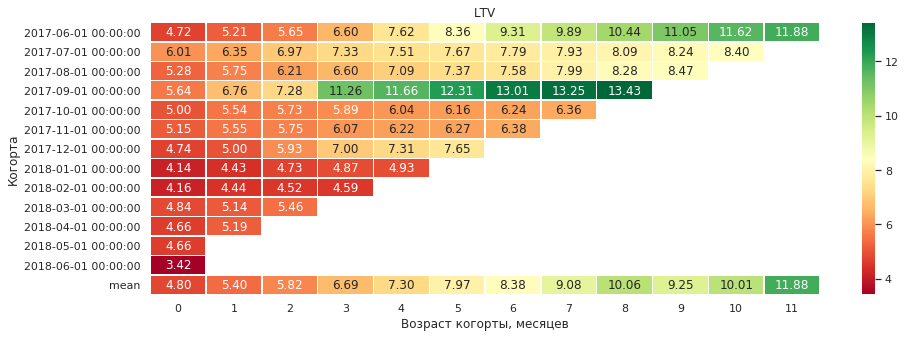

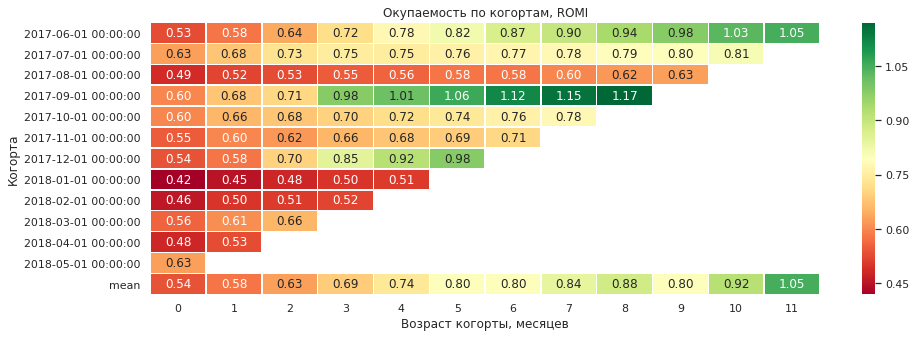

In [85]:
plt.figure(figsize=(15, 5))
plt.title('LTV')
sns.heatmap(ltv_cumsum, annot=True, fmt=".2f", linewidths=.5, cmap = 'RdYlGn')
plt.xlabel('Возраст когорты, месяцев')
plt.ylabel('Когорта')
plt.show()

plt.figure(figsize=(15, 5))
plt.title('Окупаемость по когортам, ROMI')
sns.heatmap(romi, annot=True, fmt=".2f", linewidths=.5, cmap = 'RdYlGn')
plt.xlabel('Возраст когорты, месяцев')
plt.ylabel('Когорта')
plt.show()

Затраты на маркетинг окупились только для когорты июня 2017 на 10 месяц и сентября 2017 на 4 месяц.

Для того, чтобы в среднем затраты на привлечение каждого покупателя окупались через полгода, они должны составлять менее 8,38 $

## <a id="step5"> 5. Общие выводы </a>

После проведения анализа можно сделать следующие выводы:
- чаще всего каждый пользователь совершает разовую покупку при первом посещении и забывает о сервисе. Маркетологам стоит поработать над возвратом старых клиентов. Ведь гораздо проще работать с пользователями, которые уже знакомы с сервисом и совершали покупки, чем привлекать новых;
- средний чек покупки составляет 5 долларов. В целом это неплохой показатель, особенно если увеличить количество покупок на пользователя, которое в месяц составляет лишь 1,23;
- источник привлечения клиентов №3, на который по году тратится 42% маркетингового бюджета не является самым эффективным. Он показывает неплохую конверсию (15,33%), но при этом стоимость привлечения одного покупателя для него составляет в среднем 11 долларов;
- маркетологам стоит обратить более пристальное внимание на источники 1, 9 и 10. Для которых конверсия и стоимость привлечения покупателя за исследуемый период составили 1 (15.83% / 4 ), 9 (12.08% / 3.56 ), 10 (16.42%, 4.2 ) соответственно;
- для того, чтобы средний покупатель начинал приносить прибыль через полгода на его привлечение нужно тратить порядка 8 долларов;
- возможно, стоит провести рекламные кампании, адресно направленные на когорту сентября 2017 года. Это единственная когорта, затраты на которыю вернулись уже на четвертый месяц.
- для когорт января 2018 и младше динамика выхода на окупаемость заметно снижается, нужно рассмотреть эту ситуацию более детально;
- в остальном ситуация поступательно движется к окупаемости, после пересмотра источников привлечения новых пользователей и действий, направленных на возврат старых, но неактивных, показатели должны улучшиться, а время окупаемости уменьшиться.